In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 17, 2024
Last modified on May 17, 2024
@Author: Guan-Fu Liu

To get the yields from Potinari et al. 1998,
which is the yield table in Yan's code
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import re
import h5py
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF/chemevoimf')
from scipy import interpolate
import shutil
import pyatomdb
%matplotlib widget

In [2]:
# Process the yields from AGB stars and massive stars
file_paths = [
    "./Original/NuPyCEE/Yields/other/isotope_yield_table_portinari98_marigo01_gce_totalyields.txt"
]
# Selected yields from NuPyCEE, https://github.com/NuGrid/NuPyCEE/tree/master/yield_tables

In [3]:
# We have re-define the extracted yields instead use that in utils
def extra_interpolate_yields(x1, y1, yields_type, x):
    """
    Extrapolate and interpolate the yields.

    Parameters
    ----------
    x1: numpy array
        The initial mass of the stars in the unit of solar mass.
    y1: numpy array
        The yields of the stars.
    yields_type: str
        The type of the yields. It should be 'Mrem' or an element name.
    x: float
        The initial mass of the stars in the unit of solar mass at which the yields are evaluated.
    Returns
    -------
    y: float
        Extra and interpolated yields of the stars.
    """
    interp = interpolate.interp1d(x1, y1, kind=1, fill_value='extrapolate')
    if yields_type == 'Mrem':
        # The remnant mass of the stars with mass less than the miminum mass available in the yield table is set to be 
        # its initial mass. Namely, they are assumed to experience no mass loss.
        # For consistency, their yields are set to be ZERO.
        if (x>=8) and (x<=20):
            y = interp(x)
        elif x<8:
            y = x
        else:
            y = x - x1.max() + y1[x1.argmax()]
    else:
        # For the stars with mass larger than the maximum mass available in the yield table,
        # we keep the Mini - Mrem the same as that one of the larest mass available in the yield table.
        # Namely, the additional mass is all locked in the remnant.
        # For consistency, their yields are set to be the SAME as that of the larest mass available in the yield table.
        if (x>=8) and (x<=20):
            y = interp(x)
        elif x<8:
            y = 0
        else:
            y = y1[x1.argmax()]
    return y



In [4]:
for file_path in file_paths:
    out_dir = './NuPyCEE/' + "portinari98_gce_in_igimf"
    # out_dir = './NuPyCEE/' + "isotope_yield_table_portinari98_gce_totalyields"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    shutil.copy(file_path, out_dir)
    with open (file_path, 'r') as f:
        lines = f.readlines()
    table_sep = [ ]  # To store the line number where the table starts and ends
    for i, line in enumerate(lines):
        if line.startswith("H Table:"):
            table_sep.append(i)
    tables = { }  # To store the tables

    for i, line_num in enumerate(table_sep):
        Zini = 'Z='+re.search(r"Z=(\d+(\.\d+)?)", lines[line_num]).group(1)
        if Zini in tables.keys():
            pass
        else:
            tables[Zini] = [ ]
        if i == len(table_sep)-1:
            tables[Zini].append(lines[line_num:])
        else:
            tables[Zini].append(lines[line_num:table_sep[i+1]])

    # Table of the same initial metallicity are stored in the same list
    dfs = { }  # To store the dataframes
    mass_lifetime = { }  # To store the mass and lifetime of the stars
    for Zini in tables.keys():
        if Zini in dfs.keys():
            pass
        else:
            dfs[Zini] = [ ]
            mass_lifetime[Zini] = [ ]
        for i, table in enumerate(tables[Zini]):
            for idx, item in enumerate(table):
                if item.startswith("&Isotopes"):
                    break
            table_data = [line.replace('\n', '') for line in table[idx:]]
            table_data = [line.replace('&', ' ').split() for line in table_data]
            Mini = re.search(r"M=([+-]?\d*\.?\d+[eE]?[+-]?\d*)", table[0]).group(1)
            if "igimf" in out_dir:
                if float(Mini) < 6 or float(Mini) > 20.0:
                    # Yan et al. (2019) only considers the stars with initial mass between 6 and 20 Msun
                    continue
            else:
                if float(Mini) < 6:
                    # Portinari et al. (1998) only considers the stars with initial mass larger than 6 Msun
                    continue
            df = pd.DataFrame(table_data[1:], columns=table_data[0])
            Mrem = re.search(r"Mfinal: ([+-]?\d*\.?\d+[eE][+-]?\d+)", table[2]).group(1)
            lifetime = re.search(r"Lifetime: ([+-]?\d*\.?\d+[eE][+-]?\d+)", table[1]).group(1)
            
            mass_lifetime[Zini].append([float(Mini), float(lifetime)])
            if 'X0' in df.columns:
                df = df.astype({'Isotopes':str, 'Yields':float, 'X0':float, 'Z':int, 'A':int})
            else:
                df = df.astype({'Isotopes':str, 'Yields':float, 'Z':int, 'A':int})
                df['X0'] = 0
                df = df[['Isotopes', 'Yields', 'Z', 'X0', 'A']]
            df['Isotopes'] = df['Isotopes'].str.replace(r'-\d+', '', regex=True)
            df = df.groupby('Isotopes').sum().reset_index()
            # After groupby, the order of columns is changed
            df = df[['Isotopes', 'Yields', 'Z', 'X0', 'A']]
            df['Z'] = df['Isotopes'].apply(lambda x: pyatomdb.atomic.elsymb_to_Z(x))
            # Drop the isotopes with Z>30
            df = df.loc[df['Z']<=30]
            df.loc[len(df)] = ['Mrem', float(Mrem), 0, 0, 0]
            # Z=0 for the Mrem is used to keep it in the first row
            df.loc[len(df)] = ["Other", float(Mini) - df['Yields'].sum(), 999, 0, 0]
            # Z=999 for the rest metals to keep them in the last row
            df.sort_values(by='Z', inplace=True)
            df.rename(columns={'Isotopes':'M', 'Yields':Mini}, inplace=True)
            df.drop(columns=['Z', 'X0', 'A'], inplace=True)
            df.set_index('M', inplace=True)
            # df.loc['Other'] = df.columns.to_numpy().astype(float) - df.sum(axis=0).to_numpy()
            dfs[Zini].append(df)
    for key in dfs.keys():
        # df1 are the dataframes with the same initial metallicity
        df1 = pd.concat(dfs[key], axis=1)
        df1.to_csv(os.path.join(out_dir, '%s.csv' % key))
        # Mass grids where the yields are to be extra or interpolated
        columns = ["%0.6e" % a for a in np.logspace(np.log10(0.08), np.log10(150), 300)]
        # Empty dataframe with the same index as df1
        df2 = pd.DataFrame(np.zeros((len(df1.index), len(columns))), index=df1.index, columns=columns)
        for i, row in df1.iterrows():
            x1 = row.index.to_numpy().astype(float)  # x1 is the initial mass from original yields
            y1 = row.to_numpy().astype(float)  # y1 is the remnant mass from original yields
            df2.loc[row.name, :] = [extra_interpolate_yields(x1, y1, row.name, float(col)) for col in columns]
        df2.to_csv(os.path.join(out_dir, '%s_interpolated.csv' % key))
    with h5py.File(os.path.join(out_dir, 'yields1.h5'), 'w') as f:
        url = ['https://github.com/NuGrid/NuPyCEE/blob/master/yield_tables/']
        url.append("/".join(file_path.split('/')[4:]))
        url = "".join(url)
        f.attrs['OriginalURL'] = url
        f.attrs['OriginalFile'] = file_path.split('/')[-1]
        for key in dfs.keys():
            # Create a group for each initial metallicity
            f.create_group(key)
            df1 = pd.read_csv(os.path.join(out_dir, '%s.csv' % key))
            # hdf5 does not support string with object type
            # "|S" will find the maximum length of the string in the selected column
            df1['M'] = df1['M'].astype('|S')
            data = df1.to_records(index=False)
            dtype = df1.to_records(index=False).dtype
            f[key].attrs['Z'] = "%s" % key[2:]
            f[key].attrs['MassUnit'] = 'Msun'
            f[key].create_dataset('Original', data=data, dtype=dtype)

            df2 = pd.read_csv(os.path.join(out_dir, '%s_interpolated.csv' % key))
            df2['M'] = df2['M'].astype('|S')
            data = df2.to_records(index=False)
            dtype = df2.to_records(index=False).dtype
            f[key].create_dataset('Interpolated', data=df2.to_records(), dtype=dtype)

            f[key].create_dataset('MassLifetime', data=np.array(mass_lifetime[key]))
    # Read yields1.h5
    # f = h5py.File(os.path.join(out_dir, 'yields1.h5'), 'r')

    # yields2.h5 is the other kind of hdf5 file by using to_hdf
    # but the content is the same as yields1.h5
    with h5py.File(os.path.join(out_dir, 'yields2.h5'), 'w') as f:
        url = ['https://github.com/NuGrid/NuPyCEE/blob/master/yield_tables/']
        url.append("/".join(file_path.split('/')[4:]))
        url = "".join(url)
        f.attrs['OriginalURL'] = url
        f.attrs['OriginalFile'] = file_path.split('/')[-1]
    for key in dfs.keys():
        df1 = pd.read_csv(os.path.join(out_dir, '%s.csv' % key), index_col=0)
        df1.to_hdf(os.path.join(out_dir, 'yields2.h5'), key='/%s/Original' % key.replace("=", "_").replace(".", "_"), mode='a')
        df2 = pd.read_csv(os.path.join(out_dir, '%s_interpolated.csv' % key), index_col=0)
        df2.to_hdf(os.path.join(out_dir, 'yields2.h5'), key='/%s/Interpolated' % key.replace("=", "_").replace(".", "_"), mode='a')
    # Add comments
    with h5py.File(os.path.join(out_dir, 'yields2.h5'), 'a') as f:
        for key in dfs.keys():
            f[key.replace("=", "_").replace(".", "_")].create_dataset('MassLifetime', data=np.array(mass_lifetime[key]))
            f[key.replace("=", "_").replace(".", "_")].attrs['Z'] = "%s" % key[2:]
            f[key.replace("=", "_").replace(".", "_")].attrs['MassUnit'] = 'Msun'
    
    # Read yields2.h5
    # pd.read_hdf(os.path.join(out_dir, 'yields2.h5'), key="Z_0_0004/original")

In [5]:
# Copy the NuPyCEE directory to the inputs directory
if os.path.exists('../inputs/NuPyCEE'):
    shutil.rmtree('../inputs/NuPyCEE')
shutil.copytree('./NuPyCEE', '../inputs/NuPyCEE')

'../inputs/NuPyCEE'

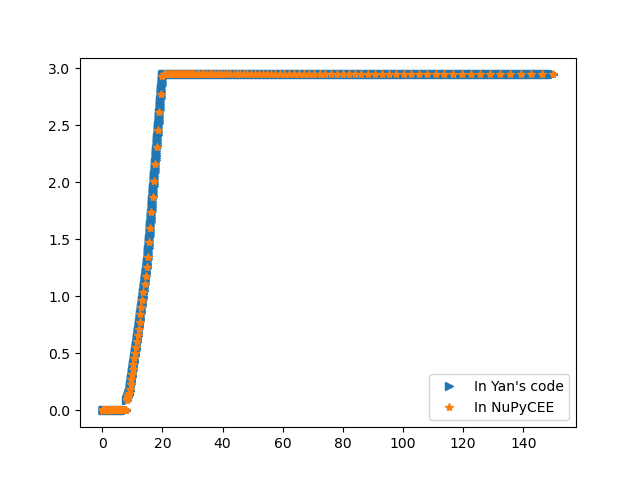

In [6]:
file_path1 = "../../galIMF/yield_tables/rearranged___/setllar_O_eject_mass_from_portinari98/portinari98_Z=0.004.txt"
f = open(file_path1, 'r')
lines1 =  f.readlines()
f.close()
Mini1 = np.array(lines1[3].split()).astype(float)
Yields1 = np.array(lines1[5].split()).astype(float)
file = h5py.File(out_dir + '/yields1.h5', 'r')
groups = list(file.keys())
df2 = pd.DataFrame(file['Z=0.004']['Interpolated'][()])
df2.loc[:,'M'] = df2.loc[:,'M'].astype(str)
df2.set_index('M', inplace=True)
fig, ax = plt.subplots()
ax.plot(Mini1, Yields1, '>', label='In Yan\'s code')
ax.plot(df2.columns.to_numpy().astype(float), df2.loc['O', :].to_numpy(), '*', label='In NuPyCEE')
# ax.set_xscale('log')
ax.legend()
plt.show()

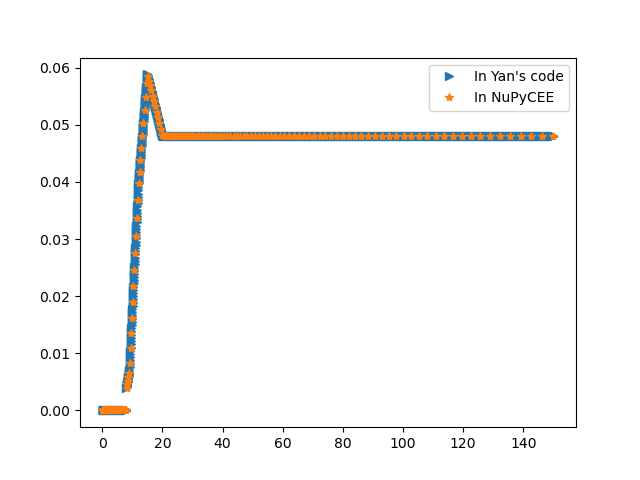

In [7]:
file_path1 = "../../galIMF/yield_tables/rearranged___/setllar_Mg_eject_mass_from_portinari98/portinari98_Z=0.004.txt"
f = open(file_path1, 'r')
lines1 =  f.readlines()
f.close()
Mini1 = np.array(lines1[3].split()).astype(float)
Yields1 = np.array(lines1[5].split()).astype(float)
file = h5py.File(out_dir + '/yields1.h5', 'r')
groups = list(file.keys())
df2 = pd.DataFrame(file['Z=0.004']['Interpolated'][()])
df2.loc[:,'M'] = df2.loc[:,'M'].astype(str)
df2.set_index('M', inplace=True)
fig, ax = plt.subplots()
ax.plot(Mini1, Yields1, '>', label='In Yan\'s code')
ax.plot(df2.columns.to_numpy().astype(float), df2.loc['Mg', :].to_numpy(), '*', label='In NuPyCEE')
# ax.set_xscale('log')
ax.legend()
plt.show()

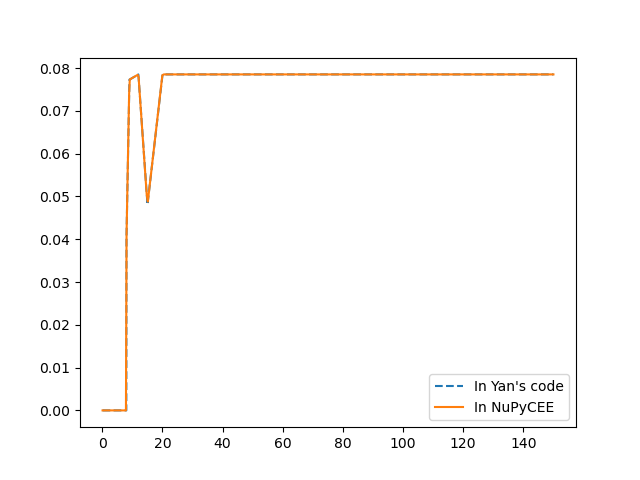

In [8]:
file_path1 = "../../galIMF/yield_tables/rearranged___/"+\
"setllar_Fe_eject_mass_from_portinari98/portinari98_Z=0.0004.txt"
f = open(file_path1, 'r')
lines1 =  f.readlines()
f.close()
Mini1 = np.array(lines1[3].split()).astype(float)
Yields1 = np.array(lines1[5].split()).astype(float)
file = h5py.File(out_dir + '/yields1.h5', 'r')
groups = list(file.keys())
df2 = pd.DataFrame(file['Z=0.0004']['Interpolated'][()])
df2.loc[:,'M'] = df2.loc[:,'M'].astype(str)
df2.set_index('M', inplace=True)
fig, ax = plt.subplots()
ax.plot(Mini1, Yields1, '--', label='In Yan\'s code')
ax.plot(df2.columns.to_numpy().astype(float), df2.loc['Fe', :].to_numpy(), '-', label='In NuPyCEE')
# ax.set_xscale('log')
ax.legend()
plt.show()

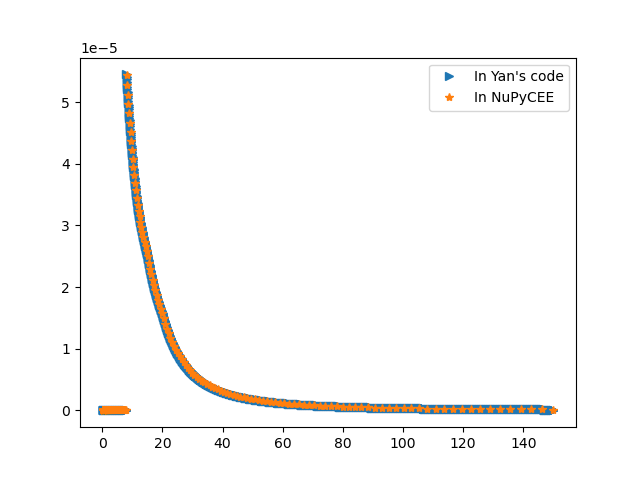

In [9]:
file_path1 = "../../galIMF/yield_tables/rearranged___/setllar_N_eject_mass_from_portinari98/portinari98_Z=0.004.txt"
f = open(file_path1, 'r')
lines1 =  f.readlines()
f.close()
Mini1 = np.array(lines1[3].split()).astype(float)
Yields1 = np.array(lines1[5].split()).astype(float)
file = h5py.File(out_dir + '/yields1.h5', 'r')
groups = list(file.keys())
df2 = pd.DataFrame(file['Z=0.004']['Interpolated'][()])
df2.loc[:,'M'] = df2.loc[:,'M'].astype(str)
df2.set_index('M', inplace=True)
fig, ax = plt.subplots()
ax.plot(Mini1, Yields1*Mini1**(-2.35), '>', label='In Yan\'s code')
ax.plot(df2.columns.to_numpy().astype(float), df2.loc['N', :].to_numpy()*df2.columns.to_numpy().astype(float)**(-2.35),
         '*', label='In NuPyCEE')
# ax.set_xscale('log')
ax.legend()
plt.show()

In [10]:
from scipy.integrate import quad

(quad(lambda x: x**(-2.35), 6, 100)[0]/quad(lambda x: x**(-1.35), 0.1, 100)[0])/\
(quad(lambda x: x**(-2.35), 6, 150)[0]/quad(lambda x: x**(-1.35), 0.08, 150)[0])

1.0915748005906578

In [11]:
quad(lambda x: x**(-2.35), 8, 150)[0]/quad(lambda x: x**(-1.35), 0.08, 150)[0]

0.0068310912312277905

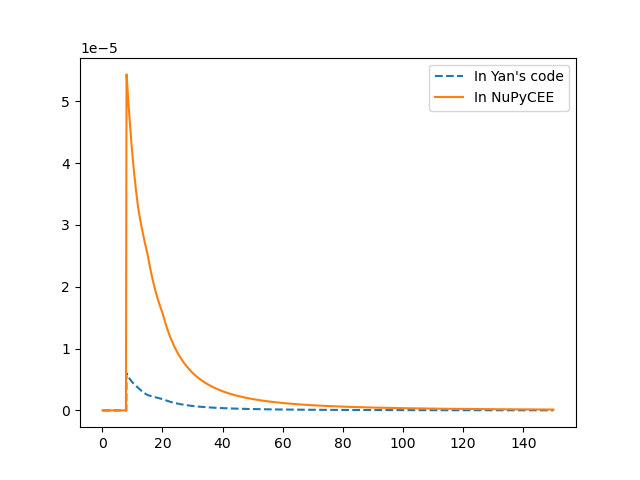

In [35]:
file_path1 = "../../galIMF/yield_tables/rearranged___/"+\
"setllar_N_eject_mass_from_portinari98/portinari98_Z=0.0004.txt"
f = open(file_path1, 'r')
lines1 =  f.readlines()
f.close()
Mini1 = np.array(lines1[3].split()).astype(float)
Yields1 = np.array(lines1[5].split()).astype(float)
file = h5py.File(out_dir + '/yields1.h5', 'r')
groups = list(file.keys())
df2 = pd.DataFrame(file['Z=0.004']['Interpolated'][()])
df2.loc[:,'M'] = df2.loc[:,'M'].astype(str)
df2.set_index('M', inplace=True)
fig, ax = plt.subplots()
ax.plot(Mini1, Yields1*Mini1**(-2.35), '--', label='In Yan\'s code')
ax.plot(df2.columns.to_numpy().astype(float), df2.loc['N', :].to_numpy()*df2.columns.to_numpy().astype(float)**(-2.35),
         '-', label='In NuPyCEE')
# ax.set_xscale('log')
ax.legend()
plt.show()
interp1 = interpolate.interp1d(Mini1, Yields1, kind=1, fill_value='extrapolate')
interp2 = interpolate.interp1d(df2.columns.to_numpy().astype(float), df2.loc['N', :].to_numpy(), kind=1, fill_value='extrapolate')


In [ ]:
quad

In [22]:
x = np.linspace(6,100,1000)
x[np.abs(interp1(x)-interp2(x)).argmax()]

7.975975975975976

In [46]:
interp1 = interpolate.interp1d(Mini1, Yields1*Mini1**(-2.35), kind=1, fill_value='extrapolate')
interp2 = interpolate.interp1d(df2.columns.to_numpy().astype(float), 
                    df2.loc['N', :].to_numpy()*df2.columns.to_numpy().astype(float)**(-2.35), kind=1, fill_value='extrapolate')
            
quad(lambda x: interp1(x), 9.7, 100)[0] / quad(lambda x: interp1(x), 6, 100)[0]

0.8567713226573299

In [41]:
56.4/6.2

9.096774193548386

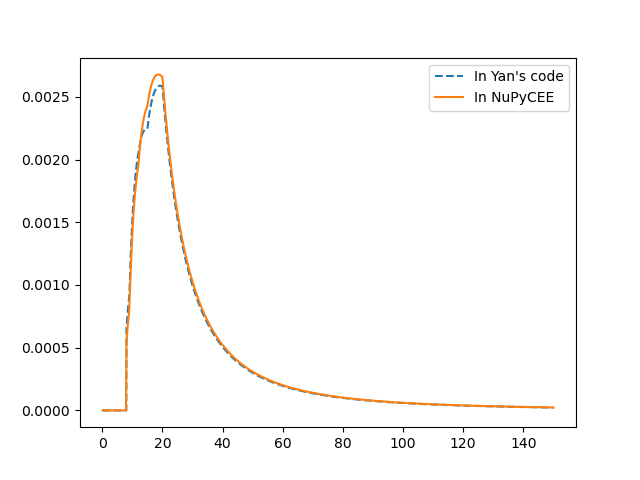

In [32]:
file_path1 = "../../galIMF/yield_tables/rearranged___/"+\
"setllar_O_eject_mass_from_portinari98/portinari98_Z=0.004.txt"
f = open(file_path1, 'r')
lines1 =  f.readlines()
f.close()
Mini1 = np.array(lines1[3].split()).astype(float)
Yields1 = np.array(lines1[5].split()).astype(float)
file = h5py.File(out_dir + '/yields1.h5', 'r')
groups = list(file.keys())
df2 = pd.DataFrame(file['Z=0.004']['Interpolated'][()])
df2.loc[:,'M'] = df2.loc[:,'M'].astype(str)
df2.set_index('M', inplace=True)
fig, ax = plt.subplots()
ax.plot(Mini1, Yields1*Mini1**(-2.35), '--', label='In Yan\'s code')
ax.plot(df2.columns.to_numpy().astype(float), df2.loc['O', :].to_numpy()*df2.columns.to_numpy().astype(float)**(-2.35),
         '-', label='In NuPyCEE')
# ax.set_xscale('log')
ax.legend()
plt.show()
interp1 = interpolate.interp1d(Mini1, Yields1, kind=1, fill_value='extrapolate')
interp2 = interpolate.interp1d(df2.columns.to_numpy().astype(float), df2.loc['O', :].to_numpy(), kind=1, fill_value='extrapolate')
